[this demo requires doom installed either from gym-pool or from [ppaquette's repo](https://github.com/ppaquette/gym-doom)]

## Basic Doom demo

* This demo solves DoomBasic env with a simple q-learning with experience replay.

# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS=device=cuda,floatX=float32

env: THEANO_FLAGS=device=cuda,floatX=float32


In [2]:
import gym
import ppaquette_gym_doom
from gym.wrappers import SkipWrapper
from ppaquette_gym_doom.wrappers.action_space import ToDiscrete
from agentnet.experiments.openai_gym.wrappers import PreprocessImage
GAME_NAME = 'ppaquette/DoomDefendLine-v0'

make_env = lambda: PreprocessImage(SkipWrapper(4)(ToDiscrete("minimal")(gym.make(GAME_NAME))),
                                   width=80,height=80,grayscale=True)

env = make_env()

Using cuDNN version 5110 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)
[2017-06-26 20:12:06,215] Making new env: ppaquette/DoomDefendLine-v0


In [3]:
#global params.
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 5

1.0 False


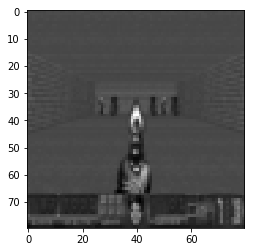

In [4]:
env.reset()
obs,r,done,_=env.step(1)
print(r, done)
plt.imshow(obs[0],cmap='gray',interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [5]:
#setup and import theano/lasagne. Prefer GPU
%env THEANO_FLAGS=device=cuda,floatX=float32

import theano, lasagne
from lasagne.layers import *

env: THEANO_FLAGS=device=cuda,floatX=float32


In [6]:
#observation
observation_layer = InputLayer((None,)+observation_shape,)

#4-tick window over images
from agentnet.memory import WindowAugmentation, LSTMCell

prev_wnd = InputLayer((None,4)+observation_shape)
new_wnd = WindowAugmentation(observation_layer,prev_wnd)
        
#reshape to (frame, h,w). If you don't use grayscale, 4 should become 12.
wnd_reshape = reshape(new_wnd, (-1,4*observation_shape[0])+observation_shape[1:])


In [7]:
from lasagne.nonlinearities import elu,tanh,softmax
#main neural network body.
#note that we use batch normalization here which speeds up training but may
#get unstable if you use small experience replay buffer
conv0 = Conv2DLayer(wnd_reshape,32,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(batch_norm(conv0),64,filter_size=(4,4),stride=(2,2),name='conv1')

dense = DenseLayer(batch_norm(conv1),512,name='dense',nonlinearity = lasagne.nonlinearities.tanh)        


In [8]:

#baseline for all qvalues
qvalues_layer = DenseLayer(dense,n_actions,nonlinearity=None,name='qval')
        
#sample actions proportionally to policy_layer
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)


In [9]:
from agentnet.target_network import TargetNetwork
targetnet = TargetNetwork(qvalues_layer)
qvalues_old = targetnet.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [10]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer,qvalues_old),
              agent_states={new_wnd:prev_wnd},
              action_layers=action_layer)


In [11]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0_bn.beta,
 conv0_bn.gamma,
 conv1.W,
 conv1_bn.beta,
 conv1_bn.gamma,
 dense.W,
 dense.b,
 qval.W,
 qval.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [12]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,make_env, 
               n_games=N_AGENTS,
               max_size=300) #experience replay pool holding last 1k sessions


[2017-06-26 20:12:07,117] Making new env: ppaquette/DoomDefendLine-v0


In [13]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_log[:2])
print(reward_log[:2])

[[2 0 3 0 0 0 0]]
[[ 0.  0.  0.  0.  0.  0.  0.]]
CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 87.4 ms


In [14]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [15]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(qvalues_seq,old_qvalues_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [16]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      qvalues_target=old_qvalues_seq,
                                                      gamma_or_gammas=0.99)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [17]:
# Compute weight updates
updates = lasagne.updates.adam(loss,weights)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [18]:
action_layer.epsilon.set_value(0)
untrained_reward = np.mean(pool.evaluate(save_path="./records",record_video=True,n_games=10))

[2017-06-26 20:12:24,004] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:12:24,014] Clearing 12 monitor files from previous run (because force=True was provided)
[2017-06-26 20:12:24,258] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.14018.video000000.mp4


Episode finished after 52 timesteps with reward=2.0


[2017-06-26 20:12:25,565] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.14018.video000001.mp4


Episode finished after 127 timesteps with reward=7.0
Episode finished after 66 timesteps with reward=1.0
Episode finished after 54 timesteps with reward=0.0
Episode finished after 116 timesteps with reward=6.0
Episode finished after 100 timesteps with reward=5.0
Episode finished after 93 timesteps with reward=5.0


[2017-06-26 20:12:34,594] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.14018.video000008.mp4


Episode finished after 85 timesteps with reward=6.0
Episode finished after 62 timesteps with reward=3.0


[2017-06-26 20:12:37,431] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Episode finished after 106 timesteps with reward=4.0


In [19]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [20]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {0:[untrained_reward]}


In [21]:
from tqdm import trange
#the loop may take eons to finish.
#consider interrupting early.
for i in trange(2000):    
    
    
    #train
    pool.update(SEQ_LENGTH,append=True)
    
    loss = train_step()
    
    targetnet.load_weights(0.01)
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.95*np.exp(-epoch_counter/200.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        
    ##record current learning progress and show learning curves
    if epoch_counter%50 ==0:
        rewards[epoch_counter] = pool.evaluate(record_video=False)
    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 11/2000 [00:01<04:12,  7.88it/s]

iter=10	epsilon=0.954	reward/step=0.05455


  1%|          | 21/2000 [00:02<04:04,  8.09it/s]

iter=20	epsilon=0.910	reward/step=0.04762


  2%|▏         | 31/2000 [00:03<04:03,  8.07it/s]

iter=30	epsilon=0.868	reward/step=0.05806


  2%|▏         | 41/2000 [00:05<04:04,  8.01it/s]

iter=40	epsilon=0.828	reward/step=0.06341


  2%|▏         | 49/2000 [00:06<04:07,  7.89it/s][2017-06-26 20:12:43,878] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:12:43,883] Clearing 8 monitor files from previous run (because force=True was provided)


iter=50	epsilon=0.790	reward/step=0.06275


[2017-06-26 20:12:44,676] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  3%|▎         | 51/2000 [00:07<09:41,  3.35it/s]

Episode finished after 40 timesteps with reward=3.0


  3%|▎         | 61/2000 [00:08<04:16,  7.56it/s]

iter=60	epsilon=0.754	reward/step=0.05574


  4%|▎         | 71/2000 [00:09<04:23,  7.33it/s]

iter=70	epsilon=0.719	reward/step=0.05915


  4%|▍         | 81/2000 [00:11<04:23,  7.27it/s]

iter=80	epsilon=0.687	reward/step=0.05926


  5%|▍         | 91/2000 [00:12<04:33,  6.97it/s]

iter=90	epsilon=0.656	reward/step=0.05495


  5%|▍         | 99/2000 [00:13<04:37,  6.86it/s][2017-06-26 20:12:51,639] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:12:51,647] Clearing 2 monitor files from previous run (because force=True was provided)


iter=100	epsilon=0.626	reward/step=0.05545


[2017-06-26 20:12:53,129] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  5%|▌         | 101/2000 [00:15<14:36,  2.17it/s]

Episode finished after 93 timesteps with reward=3.0


  6%|▌         | 111/2000 [00:17<05:16,  5.96it/s]

iter=110	epsilon=0.598	reward/step=0.05405


  6%|▌         | 121/2000 [00:18<05:02,  6.21it/s]

iter=120	epsilon=0.571	reward/step=0.05124


  7%|▋         | 131/2000 [00:20<05:08,  6.05it/s]

iter=130	epsilon=0.546	reward/step=0.04885


  7%|▋         | 141/2000 [00:22<05:11,  5.97it/s]

iter=140	epsilon=0.522	reward/step=0.05248


  7%|▋         | 149/2000 [00:23<05:12,  5.92it/s][2017-06-26 20:13:01,420] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:13:01,429] Clearing 2 monitor files from previous run (because force=True was provided)


iter=150	epsilon=0.499	reward/step=0.05166


[2017-06-26 20:13:03,972] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  8%|▊         | 151/2000 [00:26<21:46,  1.42it/s]

Episode finished after 167 timesteps with reward=12.0


  8%|▊         | 161/2000 [00:28<05:39,  5.42it/s]

iter=160	epsilon=0.477	reward/step=0.05217


  9%|▊         | 171/2000 [00:30<05:23,  5.65it/s]

iter=170	epsilon=0.456	reward/step=0.05497


  9%|▉         | 181/2000 [00:31<05:17,  5.74it/s]

iter=180	epsilon=0.436	reward/step=0.05083


 10%|▉         | 191/2000 [00:33<05:29,  5.50it/s]

iter=190	epsilon=0.417	reward/step=0.05340


 10%|▉         | 199/2000 [00:35<05:33,  5.39it/s][2017-06-26 20:13:12,925] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:13:12,933] Clearing 2 monitor files from previous run (because force=True was provided)


iter=200	epsilon=0.399	reward/step=0.05373


[2017-06-26 20:13:15,024] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 10%|█         | 201/2000 [00:37<18:47,  1.60it/s]

Episode finished after 131 timesteps with reward=10.0


 11%|█         | 211/2000 [00:39<05:54,  5.05it/s]

iter=210	epsilon=0.382	reward/step=0.05498


 11%|█         | 221/2000 [00:41<05:33,  5.34it/s]

iter=220	epsilon=0.366	reward/step=0.05158


 12%|█▏        | 231/2000 [00:43<05:36,  5.25it/s]

iter=230	epsilon=0.351	reward/step=0.05022


 12%|█▏        | 241/2000 [00:45<05:42,  5.13it/s]

iter=240	epsilon=0.336	reward/step=0.05145


 12%|█▏        | 249/2000 [00:46<05:46,  5.05it/s][2017-06-26 20:13:24,665] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:13:24,673] Clearing 2 monitor files from previous run (because force=True was provided)


iter=250	epsilon=0.322	reward/step=0.05259


[2017-06-26 20:13:25,945] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 13%|█▎        | 251/2000 [00:48<13:41,  2.13it/s]

Episode finished after 80 timesteps with reward=4.0


 13%|█▎        | 261/2000 [00:50<05:50,  4.95it/s]

iter=260	epsilon=0.309	reward/step=0.05211


 14%|█▎        | 271/2000 [00:52<05:54,  4.88it/s]

iter=270	epsilon=0.296	reward/step=0.05166


 14%|█▍        | 281/2000 [00:54<05:54,  4.84it/s]

iter=280	epsilon=0.284	reward/step=0.05196


 15%|█▍        | 291/2000 [00:56<06:03,  4.70it/s]

iter=290	epsilon=0.273	reward/step=0.05292


 15%|█▍        | 299/2000 [00:58<06:04,  4.66it/s][2017-06-26 20:13:36,370] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:13:36,375] Clearing 2 monitor files from previous run (because force=True was provided)


iter=300	epsilon=0.262	reward/step=0.05133


[2017-06-26 20:13:37,961] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 15%|█▌        | 301/2000 [01:00<15:14,  1.86it/s]

Episode finished after 97 timesteps with reward=7.0


 16%|█▌        | 311/2000 [01:02<05:42,  4.94it/s]

iter=310	epsilon=0.252	reward/step=0.05133


 16%|█▌        | 321/2000 [01:04<05:30,  5.08it/s]

iter=320	epsilon=0.242	reward/step=0.05200


 17%|█▋        | 331/2000 [01:06<05:21,  5.19it/s]

iter=330	epsilon=0.232	reward/step=0.05200


 17%|█▋        | 341/2000 [01:08<05:14,  5.28it/s]

iter=340	epsilon=0.224	reward/step=0.05067


 17%|█▋        | 349/2000 [01:09<05:17,  5.20it/s][2017-06-26 20:13:47,712] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:13:47,716] Clearing 2 monitor files from previous run (because force=True was provided)


iter=350	epsilon=0.215	reward/step=0.05000


[2017-06-26 20:13:49,241] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 18%|█▊        | 351/2000 [01:11<14:08,  1.94it/s]

Episode finished after 94 timesteps with reward=6.0


 18%|█▊        | 361/2000 [01:13<05:28,  4.99it/s]

iter=360	epsilon=0.207	reward/step=0.05133


 19%|█▊        | 371/2000 [01:15<05:16,  5.14it/s]

iter=370	epsilon=0.199	reward/step=0.05067


 19%|█▉        | 381/2000 [01:17<05:10,  5.21it/s]

iter=380	epsilon=0.192	reward/step=0.04933


 20%|█▉        | 391/2000 [01:19<05:10,  5.18it/s]

iter=390	epsilon=0.185	reward/step=0.05267


 20%|█▉        | 399/2000 [01:21<05:10,  5.15it/s][2017-06-26 20:13:59,000] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:13:59,005] Clearing 2 monitor files from previous run (because force=True was provided)


iter=400	epsilon=0.179	reward/step=0.05333


[2017-06-26 20:14:01,149] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 20%|██        | 401/2000 [01:23<17:17,  1.54it/s]

Episode finished after 136 timesteps with reward=11.0


 21%|██        | 411/2000 [01:25<05:28,  4.84it/s]

iter=410	epsilon=0.172	reward/step=0.05400


 21%|██        | 421/2000 [01:27<05:05,  5.16it/s]

iter=420	epsilon=0.166	reward/step=0.05667


 22%|██▏       | 431/2000 [01:29<05:03,  5.18it/s]

iter=430	epsilon=0.161	reward/step=0.05867


 22%|██▏       | 441/2000 [01:31<05:02,  5.15it/s]

iter=440	epsilon=0.155	reward/step=0.05733


 22%|██▏       | 449/2000 [01:33<05:00,  5.16it/s][2017-06-26 20:14:10,959] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:14:10,965] Clearing 2 monitor files from previous run (because force=True was provided)


iter=450	epsilon=0.150	reward/step=0.05867


[2017-06-26 20:14:13,627] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 23%|██▎       | 451/2000 [01:36<19:33,  1.32it/s]

Episode finished after 172 timesteps with reward=17.0


 23%|██▎       | 461/2000 [01:38<05:25,  4.73it/s]

iter=460	epsilon=0.145	reward/step=0.06067


 24%|██▎       | 471/2000 [01:40<04:56,  5.15it/s]

iter=470	epsilon=0.141	reward/step=0.06000


 24%|██▍       | 481/2000 [01:42<04:52,  5.19it/s]

iter=480	epsilon=0.136	reward/step=0.06267


 25%|██▍       | 491/2000 [01:44<04:52,  5.16it/s]

iter=490	epsilon=0.132	reward/step=0.06200


 25%|██▍       | 499/2000 [01:45<04:50,  5.17it/s][2017-06-26 20:14:23,483] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:14:23,488] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	epsilon=0.128	reward/step=0.06200


[2017-06-26 20:14:26,212] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 25%|██▌       | 501/2000 [01:48<19:16,  1.30it/s]

Episode finished after 176 timesteps with reward=17.0


 26%|██▌       | 511/2000 [01:50<05:16,  4.70it/s]

iter=510	epsilon=0.124	reward/step=0.06267


 26%|██▌       | 521/2000 [01:52<04:44,  5.19it/s]

iter=520	epsilon=0.121	reward/step=0.06800


 27%|██▋       | 531/2000 [01:54<04:39,  5.26it/s]

iter=530	epsilon=0.117	reward/step=0.06867


 27%|██▋       | 541/2000 [01:56<04:33,  5.33it/s]

iter=540	epsilon=0.114	reward/step=0.06800


 27%|██▋       | 549/2000 [01:58<04:33,  5.31it/s][2017-06-26 20:14:35,924] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:14:35,929] Clearing 2 monitor files from previous run (because force=True was provided)


iter=550	epsilon=0.111	reward/step=0.06533


[2017-06-26 20:14:37,605] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 28%|██▊       | 551/2000 [02:00<13:11,  1.83it/s]

Episode finished after 102 timesteps with reward=10.0


 28%|██▊       | 561/2000 [02:02<04:54,  4.89it/s]

iter=560	epsilon=0.108	reward/step=0.06667


 29%|██▊       | 571/2000 [02:04<04:37,  5.14it/s]

iter=570	epsilon=0.105	reward/step=0.06733


 29%|██▉       | 581/2000 [02:06<04:30,  5.24it/s]

iter=580	epsilon=0.102	reward/step=0.06800


 30%|██▉       | 591/2000 [02:08<04:30,  5.21it/s]

iter=590	epsilon=0.100	reward/step=0.06800


 30%|██▉       | 599/2000 [02:09<04:33,  5.12it/s][2017-06-26 20:14:47,409] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:14:47,414] Clearing 2 monitor files from previous run (because force=True was provided)


iter=600	epsilon=0.097	reward/step=0.07133


[2017-06-26 20:14:49,115] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 30%|███       | 601/2000 [02:11<12:58,  1.80it/s]

Episode finished after 103 timesteps with reward=10.0


 31%|███       | 611/2000 [02:13<04:41,  4.93it/s]

iter=610	epsilon=0.095	reward/step=0.07067


 31%|███       | 621/2000 [02:15<04:26,  5.17it/s]

iter=620	epsilon=0.093	reward/step=0.07200


 32%|███▏      | 631/2000 [02:17<04:24,  5.17it/s]

iter=630	epsilon=0.091	reward/step=0.07333


 32%|███▏      | 641/2000 [02:19<04:19,  5.24it/s]

iter=640	epsilon=0.089	reward/step=0.07333


 32%|███▏      | 649/2000 [02:21<04:25,  5.09it/s][2017-06-26 20:14:58,946] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:14:58,951] Clearing 2 monitor files from previous run (because force=True was provided)


iter=650	epsilon=0.087	reward/step=0.07667


[2017-06-26 20:15:01,206] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 33%|███▎      | 651/2000 [02:23<15:08,  1.48it/s]

Episode finished after 143 timesteps with reward=15.0


 33%|███▎      | 661/2000 [02:25<04:36,  4.83it/s]

iter=660	epsilon=0.085	reward/step=0.07733


 34%|███▎      | 671/2000 [02:27<04:16,  5.19it/s]

iter=670	epsilon=0.083	reward/step=0.07800


 34%|███▍      | 681/2000 [02:29<04:13,  5.21it/s]

iter=680	epsilon=0.082	reward/step=0.08000


 35%|███▍      | 691/2000 [02:31<04:12,  5.19it/s]

iter=690	epsilon=0.080	reward/step=0.07733


 35%|███▍      | 699/2000 [02:33<04:12,  5.14it/s][2017-06-26 20:15:10,989] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:15:10,993] Clearing 2 monitor files from previous run (because force=True was provided)


iter=700	epsilon=0.079	reward/step=0.07733


[2017-06-26 20:15:13,857] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 35%|███▌      | 701/2000 [02:36<17:15,  1.26it/s]

Episode finished after 189 timesteps with reward=20.0


 36%|███▌      | 711/2000 [02:38<04:34,  4.70it/s]

iter=710	epsilon=0.077	reward/step=0.07800


 36%|███▌      | 721/2000 [02:40<04:07,  5.16it/s]

iter=720	epsilon=0.076	reward/step=0.07800


 37%|███▋      | 731/2000 [02:42<04:04,  5.20it/s]

iter=730	epsilon=0.075	reward/step=0.07667


 37%|███▋      | 741/2000 [02:44<04:03,  5.16it/s]

iter=740	epsilon=0.073	reward/step=0.07733


 37%|███▋      | 749/2000 [02:45<04:03,  5.13it/s][2017-06-26 20:15:23,671] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:15:23,676] Clearing 2 monitor files from previous run (because force=True was provided)


iter=750	epsilon=0.072	reward/step=0.07667


[2017-06-26 20:15:24,649] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 38%|███▊      | 751/2000 [02:47<08:25,  2.47it/s]

Episode finished after 55 timesteps with reward=3.0


 38%|███▊      | 761/2000 [02:49<04:07,  5.01it/s]

iter=760	epsilon=0.071	reward/step=0.07533


 39%|███▊      | 771/2000 [02:51<03:57,  5.18it/s]

iter=770	epsilon=0.070	reward/step=0.07533


 39%|███▉      | 781/2000 [02:53<03:54,  5.20it/s]

iter=780	epsilon=0.069	reward/step=0.07667


 40%|███▉      | 791/2000 [02:55<03:54,  5.16it/s]

iter=790	epsilon=0.068	reward/step=0.07733


 40%|███▉      | 799/2000 [02:56<03:54,  5.12it/s][2017-06-26 20:15:34,478] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:15:34,482] Clearing 2 monitor files from previous run (because force=True was provided)


iter=800	epsilon=0.067	reward/step=0.07733


[2017-06-26 20:15:36,559] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 40%|████      | 801/2000 [02:59<12:39,  1.58it/s]

Episode finished after 130 timesteps with reward=16.0


 41%|████      | 811/2000 [03:01<04:05,  4.85it/s]

iter=810	epsilon=0.067	reward/step=0.07733


 41%|████      | 821/2000 [03:03<03:46,  5.20it/s]

iter=820	epsilon=0.066	reward/step=0.07467


 42%|████▏     | 831/2000 [03:05<03:43,  5.22it/s]

iter=830	epsilon=0.065	reward/step=0.07533


 42%|████▏     | 841/2000 [03:07<03:44,  5.16it/s]

iter=840	epsilon=0.064	reward/step=0.07533


 42%|████▏     | 849/2000 [03:08<03:44,  5.13it/s][2017-06-26 20:15:46,336] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:15:46,341] Clearing 2 monitor files from previous run (because force=True was provided)


iter=850	epsilon=0.064	reward/step=0.07800


[2017-06-26 20:15:48,398] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 43%|████▎     | 851/2000 [03:11<12:02,  1.59it/s]

Episode finished after 129 timesteps with reward=12.0


 43%|████▎     | 861/2000 [03:13<03:52,  4.90it/s]

iter=860	epsilon=0.063	reward/step=0.07800


 44%|████▎     | 871/2000 [03:14<03:39,  5.15it/s]

iter=870	epsilon=0.062	reward/step=0.07800


 44%|████▍     | 881/2000 [03:16<03:45,  4.97it/s]

iter=880	epsilon=0.062	reward/step=0.07667


 45%|████▍     | 891/2000 [03:18<03:33,  5.19it/s]

iter=890	epsilon=0.061	reward/step=0.07733


 45%|████▍     | 899/2000 [03:20<03:36,  5.08it/s][2017-06-26 20:15:58,231] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:15:58,236] Clearing 2 monitor files from previous run (because force=True was provided)


iter=900	epsilon=0.061	reward/step=0.07667


[2017-06-26 20:16:00,206] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 45%|████▌     | 901/2000 [03:22<11:11,  1.64it/s]

Episode finished after 125 timesteps with reward=12.0


 46%|████▌     | 911/2000 [03:24<03:43,  4.88it/s]

iter=910	epsilon=0.060	reward/step=0.07867


 46%|████▌     | 921/2000 [03:26<03:26,  5.21it/s]

iter=920	epsilon=0.060	reward/step=0.07800


 47%|████▋     | 931/2000 [03:28<03:26,  5.18it/s]

iter=930	epsilon=0.059	reward/step=0.07667


 47%|████▋     | 941/2000 [03:30<03:22,  5.22it/s]

iter=940	epsilon=0.059	reward/step=0.07867


 47%|████▋     | 949/2000 [03:32<03:24,  5.14it/s][2017-06-26 20:16:09,968] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:16:09,973] Clearing 2 monitor files from previous run (because force=True was provided)


iter=950	epsilon=0.058	reward/step=0.07533


[2017-06-26 20:16:13,779] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 48%|████▊     | 951/2000 [03:36<17:25,  1.00it/s]

Episode finished after 257 timesteps with reward=26.0


 48%|████▊     | 961/2000 [03:38<03:42,  4.67it/s]

iter=960	epsilon=0.058	reward/step=0.07667


 49%|████▊     | 971/2000 [03:40<03:18,  5.18it/s]

iter=970	epsilon=0.057	reward/step=0.07800


 49%|████▉     | 981/2000 [03:42<03:16,  5.20it/s]

iter=980	epsilon=0.057	reward/step=0.07933


 50%|████▉     | 991/2000 [03:44<03:12,  5.23it/s]

iter=990	epsilon=0.057	reward/step=0.08067


 50%|████▉     | 999/2000 [03:45<03:14,  5.16it/s][2017-06-26 20:16:23,534] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:16:23,539] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	epsilon=0.056	reward/step=0.08200


[2017-06-26 20:16:25,977] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 50%|█████     | 1001/2000 [03:48<11:46,  1.41it/s]

Episode finished after 158 timesteps with reward=18.0


 51%|█████     | 1011/2000 [03:50<03:25,  4.80it/s]

iter=1010	epsilon=0.056	reward/step=0.08333


 51%|█████     | 1021/2000 [03:52<03:09,  5.16it/s]

iter=1020	epsilon=0.056	reward/step=0.08400


 52%|█████▏    | 1031/2000 [03:54<03:08,  5.13it/s]

iter=1030	epsilon=0.056	reward/step=0.08333


 52%|█████▏    | 1041/2000 [03:56<03:04,  5.20it/s]

iter=1040	epsilon=0.055	reward/step=0.08333


 52%|█████▏    | 1049/2000 [03:58<03:06,  5.09it/s][2017-06-26 20:16:35,810] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:16:35,814] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1050	epsilon=0.055	reward/step=0.08600


[2017-06-26 20:16:38,088] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 53%|█████▎    | 1051/2000 [04:00<10:42,  1.48it/s]

Episode finished after 145 timesteps with reward=18.0


 53%|█████▎    | 1061/2000 [04:02<03:14,  4.82it/s]

iter=1060	epsilon=0.055	reward/step=0.08600


 54%|█████▎    | 1071/2000 [04:04<02:59,  5.18it/s]

iter=1070	epsilon=0.055	reward/step=0.08600


 54%|█████▍    | 1081/2000 [04:06<02:57,  5.17it/s]

iter=1080	epsilon=0.054	reward/step=0.08533


 55%|█████▍    | 1091/2000 [04:08<02:54,  5.21it/s]

iter=1090	epsilon=0.054	reward/step=0.08467


 55%|█████▍    | 1099/2000 [04:10<02:55,  5.14it/s][2017-06-26 20:16:47,882] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:16:47,887] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1100	epsilon=0.054	reward/step=0.08800


[2017-06-26 20:16:51,318] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 55%|█████▌    | 1101/2000 [04:13<13:44,  1.09it/s]

Episode finished after 226 timesteps with reward=26.0


 56%|█████▌    | 1111/2000 [04:15<03:10,  4.67it/s]

iter=1110	epsilon=0.054	reward/step=0.08733


 56%|█████▌    | 1121/2000 [04:17<02:50,  5.15it/s]

iter=1120	epsilon=0.054	reward/step=0.08733


 57%|█████▋    | 1131/2000 [04:19<02:47,  5.19it/s]

iter=1130	epsilon=0.053	reward/step=0.08733


 57%|█████▋    | 1141/2000 [04:21<02:43,  5.24it/s]

iter=1140	epsilon=0.053	reward/step=0.08800


 57%|█████▋    | 1149/2000 [04:23<02:46,  5.11it/s][2017-06-26 20:17:01,106] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:17:01,111] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1150	epsilon=0.053	reward/step=0.08867


[2017-06-26 20:17:03,207] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 58%|█████▊    | 1151/2000 [04:25<09:01,  1.57it/s]

Episode finished after 132 timesteps with reward=17.0


 58%|█████▊    | 1161/2000 [04:27<02:52,  4.86it/s]

iter=1160	epsilon=0.053	reward/step=0.08933


 59%|█████▊    | 1171/2000 [04:29<02:41,  5.14it/s]

iter=1170	epsilon=0.053	reward/step=0.09067


 59%|█████▉    | 1181/2000 [04:31<02:39,  5.12it/s]

iter=1180	epsilon=0.053	reward/step=0.09200


 60%|█████▉    | 1191/2000 [04:33<02:37,  5.13it/s]

iter=1190	epsilon=0.052	reward/step=0.09200


 60%|█████▉    | 1199/2000 [04:35<02:36,  5.11it/s][2017-06-26 20:17:13,071] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:17:13,075] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1200	epsilon=0.052	reward/step=0.09400


[2017-06-26 20:17:16,275] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 60%|██████    | 1201/2000 [04:38<11:37,  1.15it/s]

Episode finished after 213 timesteps with reward=26.0


 61%|██████    | 1211/2000 [04:40<02:47,  4.71it/s]

iter=1210	epsilon=0.052	reward/step=0.09400


 61%|██████    | 1221/2000 [04:42<02:30,  5.18it/s]

iter=1220	epsilon=0.052	reward/step=0.09533


 62%|██████▏   | 1231/2000 [04:44<02:28,  5.18it/s]

iter=1230	epsilon=0.052	reward/step=0.09667


 62%|██████▏   | 1241/2000 [04:46<02:27,  5.14it/s]

iter=1240	epsilon=0.052	reward/step=0.09600


 62%|██████▏   | 1249/2000 [04:48<02:24,  5.20it/s][2017-06-26 20:17:26,081] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:17:26,086] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1250	epsilon=0.052	reward/step=0.09600


[2017-06-26 20:17:28,390] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 63%|██████▎   | 1251/2000 [04:51<08:30,  1.47it/s]

Episode finished after 148 timesteps with reward=19.0


 63%|██████▎   | 1261/2000 [04:53<02:32,  4.84it/s]

iter=1260	epsilon=0.052	reward/step=0.09667


 64%|██████▎   | 1271/2000 [04:54<02:21,  5.14it/s]

iter=1270	epsilon=0.052	reward/step=0.09600


 64%|██████▍   | 1281/2000 [04:56<02:18,  5.19it/s]

iter=1280	epsilon=0.052	reward/step=0.09333


 65%|██████▍   | 1291/2000 [04:58<02:17,  5.14it/s]

iter=1290	epsilon=0.052	reward/step=0.09333


 65%|██████▍   | 1299/2000 [05:00<02:16,  5.15it/s][2017-06-26 20:17:38,205] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:17:38,210] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1300	epsilon=0.051	reward/step=0.09267


[2017-06-26 20:17:40,348] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 65%|██████▌   | 1301/2000 [05:03<07:31,  1.55it/s]

Episode finished after 136 timesteps with reward=17.0


 66%|██████▌   | 1311/2000 [05:04<02:22,  4.85it/s]

iter=1310	epsilon=0.051	reward/step=0.09200


 66%|██████▌   | 1321/2000 [05:06<02:12,  5.12it/s]

iter=1320	epsilon=0.051	reward/step=0.08933


 67%|██████▋   | 1331/2000 [05:08<02:08,  5.21it/s]

iter=1330	epsilon=0.051	reward/step=0.09200


 67%|██████▋   | 1341/2000 [05:10<02:07,  5.17it/s]

iter=1340	epsilon=0.051	reward/step=0.09267


 67%|██████▋   | 1349/2000 [05:12<02:07,  5.10it/s][2017-06-26 20:17:50,175] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:17:50,180] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1350	epsilon=0.051	reward/step=0.09200


[2017-06-26 20:17:53,163] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 68%|██████▊   | 1351/2000 [05:15<08:54,  1.21it/s]

Episode finished after 193 timesteps with reward=19.0


 68%|██████▊   | 1361/2000 [05:17<02:15,  4.70it/s]

iter=1360	epsilon=0.051	reward/step=0.09200


 69%|██████▊   | 1371/2000 [05:19<02:01,  5.16it/s]

iter=1370	epsilon=0.051	reward/step=0.09400


 69%|██████▉   | 1381/2000 [05:21<02:00,  5.14it/s]

iter=1380	epsilon=0.051	reward/step=0.09467


 70%|██████▉   | 1391/2000 [05:23<01:57,  5.19it/s]

iter=1390	epsilon=0.051	reward/step=0.09333


 70%|██████▉   | 1399/2000 [05:25<01:57,  5.11it/s][2017-06-26 20:18:02,977] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:18:02,982] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1400	epsilon=0.051	reward/step=0.09133


[2017-06-26 20:18:03,807] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 70%|███████   | 1401/2000 [05:26<03:42,  2.69it/s]

Episode finished after 45 timesteps with reward=2.0


 71%|███████   | 1411/2000 [05:28<01:56,  5.06it/s]

iter=1410	epsilon=0.051	reward/step=0.09267


 71%|███████   | 1421/2000 [05:30<01:48,  5.35it/s]

iter=1420	epsilon=0.051	reward/step=0.09267


 72%|███████▏  | 1431/2000 [05:32<01:46,  5.33it/s]

iter=1430	epsilon=0.051	reward/step=0.09200


 72%|███████▏  | 1441/2000 [05:34<01:44,  5.34it/s]

iter=1440	epsilon=0.051	reward/step=0.09133


 72%|███████▏  | 1449/2000 [05:35<01:44,  5.27it/s][2017-06-26 20:18:13,442] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:18:13,447] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1450	epsilon=0.051	reward/step=0.09000


[2017-06-26 20:18:14,768] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 73%|███████▎  | 1451/2000 [05:37<04:19,  2.12it/s]

Episode finished after 81 timesteps with reward=8.0


 73%|███████▎  | 1461/2000 [05:39<01:48,  4.97it/s]

iter=1460	epsilon=0.051	reward/step=0.09067


 74%|███████▎  | 1471/2000 [05:41<01:42,  5.18it/s]

iter=1470	epsilon=0.051	reward/step=0.09067


 74%|███████▍  | 1481/2000 [05:43<01:39,  5.19it/s]

iter=1480	epsilon=0.051	reward/step=0.08933


 75%|███████▍  | 1491/2000 [05:45<01:37,  5.22it/s]

iter=1490	epsilon=0.051	reward/step=0.08933


 75%|███████▍  | 1499/2000 [05:46<01:37,  5.12it/s][2017-06-26 20:18:24,578] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:18:24,583] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1500	epsilon=0.051	reward/step=0.08933


[2017-06-26 20:18:26,314] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 75%|███████▌  | 1501/2000 [05:48<04:40,  1.78it/s]

Episode finished after 110 timesteps with reward=12.0


 76%|███████▌  | 1511/2000 [05:50<01:37,  5.00it/s]

iter=1510	epsilon=0.050	reward/step=0.08800


 76%|███████▌  | 1521/2000 [05:52<01:31,  5.22it/s]

iter=1520	epsilon=0.050	reward/step=0.08667


 77%|███████▋  | 1531/2000 [05:54<01:30,  5.18it/s]

iter=1530	epsilon=0.050	reward/step=0.08600


 77%|███████▋  | 1541/2000 [05:56<01:28,  5.16it/s]

iter=1540	epsilon=0.050	reward/step=0.08667


 77%|███████▋  | 1549/2000 [05:58<01:25,  5.26it/s][2017-06-26 20:18:36,033] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:18:36,038] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1550	epsilon=0.050	reward/step=0.08667


[2017-06-26 20:18:38,702] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 78%|███████▊  | 1551/2000 [06:01<05:38,  1.33it/s]

Episode finished after 173 timesteps with reward=18.0


 78%|███████▊  | 1561/2000 [06:03<01:29,  4.89it/s]

iter=1560	epsilon=0.050	reward/step=0.08333


 79%|███████▊  | 1571/2000 [06:05<01:22,  5.18it/s]

iter=1570	epsilon=0.050	reward/step=0.08400


 79%|███████▉  | 1581/2000 [06:07<01:21,  5.14it/s]

iter=1580	epsilon=0.050	reward/step=0.08600


 80%|███████▉  | 1591/2000 [06:09<01:19,  5.17it/s]

iter=1590	epsilon=0.050	reward/step=0.08667


 80%|███████▉  | 1599/2000 [06:10<01:18,  5.13it/s][2017-06-26 20:18:48,470] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:18:48,474] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1600	epsilon=0.050	reward/step=0.08600


[2017-06-26 20:18:50,310] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 80%|████████  | 1601/2000 [06:12<03:53,  1.71it/s]

Episode finished after 113 timesteps with reward=13.0


 81%|████████  | 1611/2000 [06:14<01:19,  4.90it/s]

iter=1610	epsilon=0.050	reward/step=0.08533


 81%|████████  | 1621/2000 [06:16<01:12,  5.22it/s]

iter=1620	epsilon=0.050	reward/step=0.08533


 82%|████████▏ | 1631/2000 [06:18<01:11,  5.15it/s]

iter=1630	epsilon=0.050	reward/step=0.08600


 82%|████████▏ | 1641/2000 [06:20<01:09,  5.18it/s]

iter=1640	epsilon=0.050	reward/step=0.08600


 82%|████████▏ | 1649/2000 [06:22<01:08,  5.09it/s][2017-06-26 20:19:00,131] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:19:00,136] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1650	epsilon=0.050	reward/step=0.08600


[2017-06-26 20:19:02,995] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 83%|████████▎ | 1651/2000 [06:25<04:38,  1.25it/s]

Episode finished after 192 timesteps with reward=19.0


 83%|████████▎ | 1661/2000 [06:27<01:11,  4.74it/s]

iter=1660	epsilon=0.050	reward/step=0.08733


 84%|████████▎ | 1671/2000 [06:29<01:02,  5.23it/s]

iter=1670	epsilon=0.050	reward/step=0.08467


 84%|████████▍ | 1681/2000 [06:31<01:01,  5.17it/s]

iter=1680	epsilon=0.050	reward/step=0.08533


 85%|████████▍ | 1691/2000 [06:33<00:59,  5.20it/s]

iter=1690	epsilon=0.050	reward/step=0.08600


 85%|████████▍ | 1699/2000 [06:35<00:58,  5.16it/s][2017-06-26 20:19:12,777] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:19:12,782] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1700	epsilon=0.050	reward/step=0.08667


[2017-06-26 20:19:15,715] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 85%|████████▌ | 1701/2000 [06:38<04:02,  1.23it/s]

Episode finished after 193 timesteps with reward=22.0


 86%|████████▌ | 1711/2000 [06:40<01:00,  4.76it/s]

iter=1710	epsilon=0.050	reward/step=0.08600


 86%|████████▌ | 1721/2000 [06:42<00:54,  5.15it/s]

iter=1720	epsilon=0.050	reward/step=0.08800


 87%|████████▋ | 1731/2000 [06:44<00:52,  5.14it/s]

iter=1730	epsilon=0.050	reward/step=0.09000


 87%|████████▋ | 1741/2000 [06:46<00:49,  5.27it/s]

iter=1740	epsilon=0.050	reward/step=0.08867


 87%|████████▋ | 1749/2000 [06:47<00:49,  5.07it/s][2017-06-26 20:19:25,508] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:19:25,513] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1750	epsilon=0.050	reward/step=0.09133


[2017-06-26 20:19:27,076] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 88%|████████▊ | 1751/2000 [06:49<02:11,  1.90it/s]

Episode finished after 93 timesteps with reward=11.0


 88%|████████▊ | 1761/2000 [06:51<00:48,  4.95it/s]

iter=1760	epsilon=0.050	reward/step=0.08933


 89%|████████▊ | 1771/2000 [06:53<00:44,  5.17it/s]

iter=1770	epsilon=0.050	reward/step=0.08933


 89%|████████▉ | 1781/2000 [06:55<00:41,  5.22it/s]

iter=1780	epsilon=0.050	reward/step=0.09133


 90%|████████▉ | 1791/2000 [06:57<00:40,  5.14it/s]

iter=1790	epsilon=0.050	reward/step=0.09067


 90%|████████▉ | 1799/2000 [06:59<00:39,  5.06it/s][2017-06-26 20:19:36,896] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:19:36,900] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1800	epsilon=0.050	reward/step=0.08933


[2017-06-26 20:19:39,795] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 90%|█████████ | 1801/2000 [07:02<02:40,  1.24it/s]

Episode finished after 190 timesteps with reward=22.0


 91%|█████████ | 1811/2000 [07:04<00:39,  4.74it/s]

iter=1810	epsilon=0.050	reward/step=0.09067


 91%|█████████ | 1821/2000 [07:06<00:34,  5.17it/s]

iter=1820	epsilon=0.050	reward/step=0.09133


 92%|█████████▏| 1831/2000 [07:08<00:31,  5.30it/s]

iter=1830	epsilon=0.050	reward/step=0.09000


 92%|█████████▏| 1841/2000 [07:10<00:29,  5.33it/s]

iter=1840	epsilon=0.050	reward/step=0.08733


 92%|█████████▏| 1849/2000 [07:11<00:28,  5.26it/s][2017-06-26 20:19:49,466] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:19:49,471] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1850	epsilon=0.050	reward/step=0.08800


[2017-06-26 20:19:52,142] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 93%|█████████▎| 1851/2000 [07:14<01:52,  1.32it/s]

Episode finished after 174 timesteps with reward=17.0


 93%|█████████▎| 1861/2000 [07:16<00:28,  4.94it/s]

iter=1860	epsilon=0.050	reward/step=0.08867


 94%|█████████▎| 1871/2000 [07:18<00:24,  5.17it/s]

iter=1870	epsilon=0.050	reward/step=0.08733


 94%|█████████▍| 1881/2000 [07:20<00:23,  5.17it/s]

iter=1880	epsilon=0.050	reward/step=0.08733


 95%|█████████▍| 1891/2000 [07:22<00:21,  5.13it/s]

iter=1890	epsilon=0.050	reward/step=0.08600


 95%|█████████▍| 1899/2000 [07:24<00:19,  5.09it/s][2017-06-26 20:20:01,916] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:20:01,921] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1900	epsilon=0.050	reward/step=0.08667


[2017-06-26 20:20:04,242] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 95%|█████████▌| 1900/2000 [07:26<01:31,  1.10it/s]

Episode finished after 148 timesteps with reward=18.0


 96%|█████████▌| 1911/2000 [07:28<00:18,  4.86it/s]

iter=1910	epsilon=0.050	reward/step=0.08733


 96%|█████████▌| 1921/2000 [07:30<00:15,  5.16it/s]

iter=1920	epsilon=0.050	reward/step=0.08933


 97%|█████████▋| 1931/2000 [07:32<00:13,  5.22it/s]

iter=1930	epsilon=0.050	reward/step=0.09000


 97%|█████████▋| 1941/2000 [07:34<00:11,  5.22it/s]

iter=1940	epsilon=0.050	reward/step=0.09000


 97%|█████████▋| 1949/2000 [07:36<00:09,  5.14it/s][2017-06-26 20:20:14,003] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:20:14,008] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1950	epsilon=0.050	reward/step=0.08867


[2017-06-26 20:20:16,020] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 98%|█████████▊| 1951/2000 [07:38<00:30,  1.62it/s]

Episode finished after 127 timesteps with reward=16.0


 98%|█████████▊| 1961/2000 [07:40<00:08,  4.77it/s]

iter=1960	epsilon=0.050	reward/step=0.08667


 99%|█████████▊| 1971/2000 [07:42<00:05,  5.12it/s]

iter=1970	epsilon=0.050	reward/step=0.08667


 99%|█████████▉| 1981/2000 [07:44<00:03,  5.23it/s]

iter=1980	epsilon=0.050	reward/step=0.08600


100%|█████████▉| 1991/2000 [07:46<00:01,  5.16it/s]

iter=1990	epsilon=0.050	reward/step=0.08733


100%|█████████▉| 1999/2000 [07:48<00:00,  5.21it/s][2017-06-26 20:20:25,829] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:20:25,833] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2000	epsilon=0.050	reward/step=0.08533


[2017-06-26 20:20:28,036] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
100%|██████████| 2000/2000 [07:50<00:00,  1.15it/s]

Episode finished after 140 timesteps with reward=16.0


# Evaluating results
 * Here we plot learning curves and sample testimonials

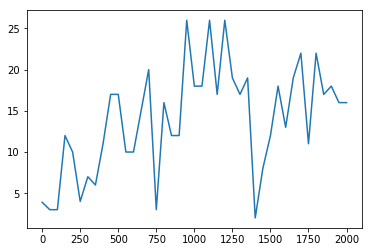

In [22]:
time,rw = zip(*sorted(list(rewards.items()),key=lambda p:p[0]))
plt.plot(time,list(map(np.mean,rw)))
    

In [23]:
with open('{}'.format(GAME_NAME.split('/')[1]), 'w') as outp:
    for idx in range(len(time)):
        print(time[idx], rw[idx], file=outp)

In [24]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=100,save_path="./records",record_video=True)
print("mean session score=%f.5"%np.mean(rw))

[2017-06-26 20:20:28,252] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 20:20:28,260] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-06-26 20:20:28,503] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.14018.video000000.mp4


Episode finished after 91 timesteps with reward=10.0


[2017-06-26 20:20:30,833] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.14018.video000001.mp4


Episode finished after 93 timesteps with reward=12.0
Episode finished after 93 timesteps with reward=11.0
Episode finished after 44 timesteps with reward=2.0
Episode finished after 165 timesteps with reward=17.0
Episode finished after 142 timesteps with reward=18.0
Episode finished after 80 timesteps with reward=7.0


[2017-06-26 20:20:42,582] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.14018.video000008.mp4


Episode finished after 153 timesteps with reward=18.0
Episode finished after 161 timesteps with reward=19.0
Episode finished after 61 timesteps with reward=4.0
Episode finished after 95 timesteps with reward=8.0
Episode finished after 171 timesteps with reward=21.0
Episode finished after 201 timesteps with reward=25.0
Episode finished after 76 timesteps with reward=6.0
Episode finished after 99 timesteps with reward=12.0
Episode finished after 121 timesteps with reward=14.0
Episode finished after 229 timesteps with reward=26.0
Episode finished after 187 timesteps with reward=21.0
Episode finished after 201 timesteps with reward=23.0
Episode finished after 69 timesteps with reward=5.0
Episode finished after 202 timesteps with reward=25.0
Episode finished after 140 timesteps with reward=16.0
Episode finished after 140 timesteps with reward=15.0
Episode finished after 137 timesteps with reward=15.0
Episode finished after 112 timesteps with reward=14.0
Episode finished after 256 timesteps 

[2017-06-26 20:21:23,042] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.14018.video000027.mp4


Episode finished after 141 timesteps with reward=17.0
Episode finished after 144 timesteps with reward=16.0
Episode finished after 229 timesteps with reward=26.0
Episode finished after 244 timesteps with reward=29.0
Episode finished after 208 timesteps with reward=25.0
Episode finished after 85 timesteps with reward=9.0
Episode finished after 132 timesteps with reward=18.0
Episode finished after 229 timesteps with reward=25.0
Episode finished after 162 timesteps with reward=16.0
Episode finished after 145 timesteps with reward=17.0
Episode finished after 178 timesteps with reward=22.0
Episode finished after 189 timesteps with reward=24.0
Episode finished after 264 timesteps with reward=28.0
Episode finished after 143 timesteps with reward=17.0
Episode finished after 193 timesteps with reward=22.0
Episode finished after 219 timesteps with reward=26.0
Episode finished after 210 timesteps with reward=22.0
Episode finished after 243 timesteps with reward=26.0
Episode finished after 171 tim

[2017-06-26 20:22:50,936] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.14018.video000064.mp4


Episode finished after 242 timesteps with reward=28.0
Episode finished after 159 timesteps with reward=17.0
Episode finished after 128 timesteps with reward=14.0
Episode finished after 190 timesteps with reward=21.0
Episode finished after 206 timesteps with reward=23.0
Episode finished after 106 timesteps with reward=11.0
Episode finished after 65 timesteps with reward=6.0
Episode finished after 89 timesteps with reward=9.0
Episode finished after 134 timesteps with reward=15.0
Episode finished after 93 timesteps with reward=6.0
Episode finished after 207 timesteps with reward=25.0
Episode finished after 148 timesteps with reward=19.0
Episode finished after 179 timesteps with reward=19.0
Episode finished after 88 timesteps with reward=10.0
Episode finished after 262 timesteps with reward=29.0
Episode finished after 112 timesteps with reward=11.0
Episode finished after 133 timesteps with reward=16.0
Episode finished after 92 timesteps with reward=10.0
Episode finished after 112 timesteps

[2017-06-26 20:24:02,902] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Episode finished after 133 timesteps with reward=14.0
mean session score=16.810000.5


In [26]:
gym.scoreboard.api_key = 'sk_X6PO6hv9Rq24jaL21xROSA'
gym.upload('/home/ubuntu/records')

[2017-06-26 20:26:02,462] [DoomDefendLine-v0] Uploading 100 episodes of training data
[2017-06-26 20:26:02,722] [DoomDefendLine-v0] Uploading videos of 5 training episodes (4840171 bytes)
[2017-06-26 20:26:02,899] [DoomDefendLine-v0] Creating evaluation object from /home/ubuntu/records with learning curve and training video
[2017-06-26 20:26:03,899] 
****************************************************
You successfully uploaded your evaluation on DoomDefendLine-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_WRUZju0qQNuEIsheS9mw

****************************************************


In [ ]:
from agentnet.utils.persistence import save,load
#save for display
save(action_layer,"{}.pcl".format(GAME_NAME.split('/')[1]))

In [ ]:
from IPython.display import HTML
import os
from random import choice
#select the one you want
videos = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))
video_path="./records/"+choice(videos)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


## Get serious

* Switch to DoomDefendCenter, DoomHealthGathering, DoomDeathmatch or similar
* Deploy a better RL algorithm
* Deploy a better network. Doom will likely need some recurrent nets